In [41]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [42]:
import FinanceDataReader as fdr

# 삼성전자

In [185]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-17,65900,66800,64400,66700,39448683,0.030912
2025-07-18,67000,67800,66300,67100,23951531,0.005997
2025-07-21,67400,68800,67200,67800,17723148,0.010432
2025-07-22,68100,68500,65600,66000,20829006,-0.026549
2025-07-23,66200,66500,64900,66400,15687058,0.006061


# 분석 코드

In [186]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

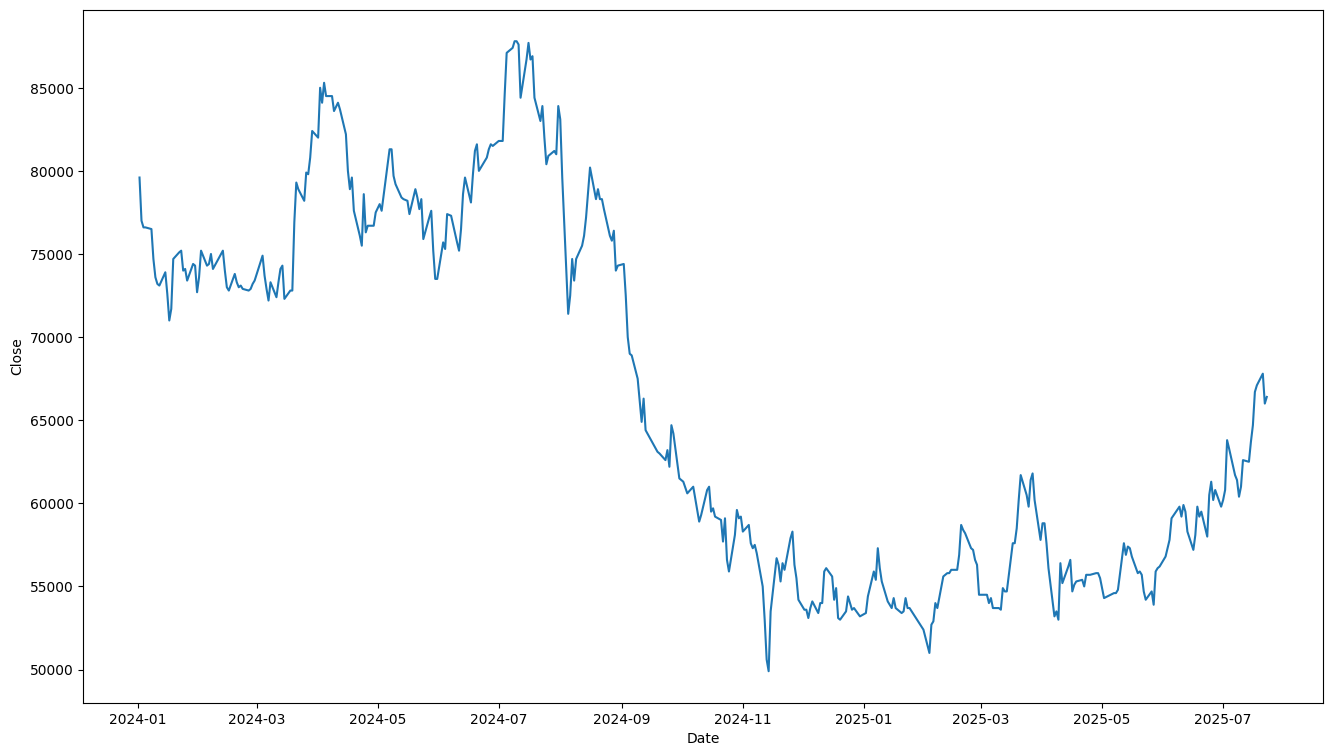

In [188]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [189]:
#종가 제외 스케일링 (반응변수 = 종가)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df[['Open', 'High', 'Low', 'Volume']] = scaler_x.fit_transform(df[['Open', 'High', 'Low', 'Volume']])
df['Close_scaled'] = scaler_y.fit_transform(df[['Close']])

In [190]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close_scaled'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [191]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [192]:
x_train_seq

tensor([[[0.7311, 0.7594, 0.7608, 0.2179],
         [0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011]],

        [[0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891]],

        [[0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891],
         [0.6475, 0.6364, 0.6263, 0.2780]],

        ...,

        [[0.2089, 0.1898, 0.1801, 0.4948],
         [0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989, 0.4344],
         [0.2324, 0.2246, 0.2339, 0.2699]],

        [[0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989

In [193]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

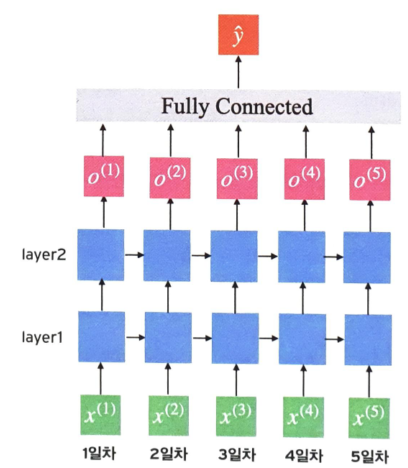

In [194]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 32

In [195]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Linear(hidden_size * sequence_length, 1) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [196]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [197]:
criterion = nn.MSELoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [198]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0558
[epoch : 10] loss: 0.0039
[epoch : 20] loss: 0.0028
[epoch : 30] loss: 0.0025
[epoch : 40] loss: 0.0034
[epoch : 50] loss: 0.0022
[epoch : 60] loss: 0.0025
[epoch : 70] loss: 0.0029
[epoch : 80] loss: 0.0021
[epoch : 90] loss: 0.0019


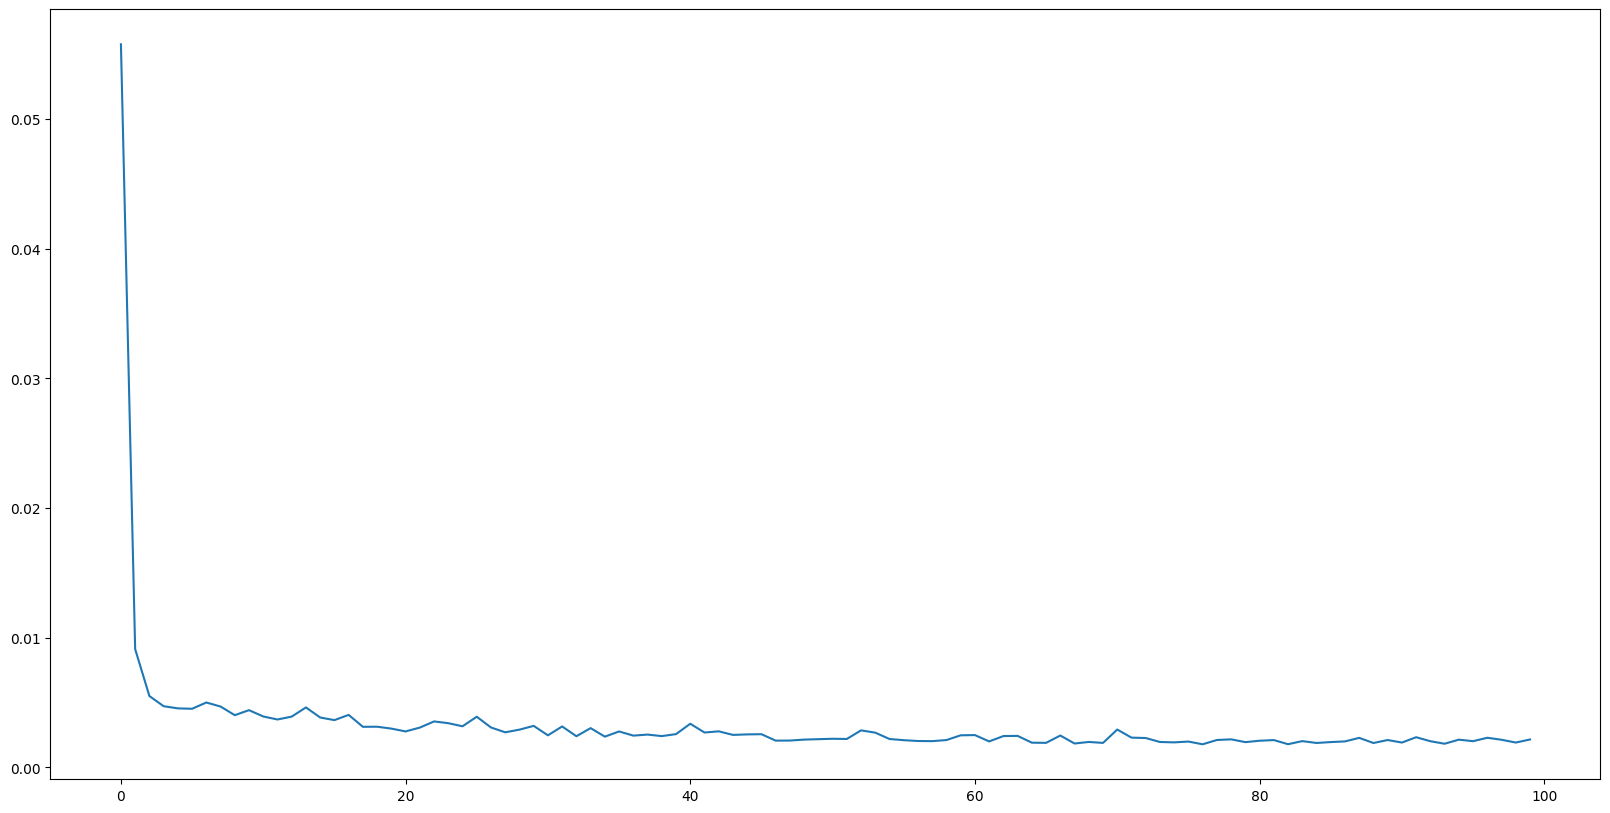

In [199]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [200]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

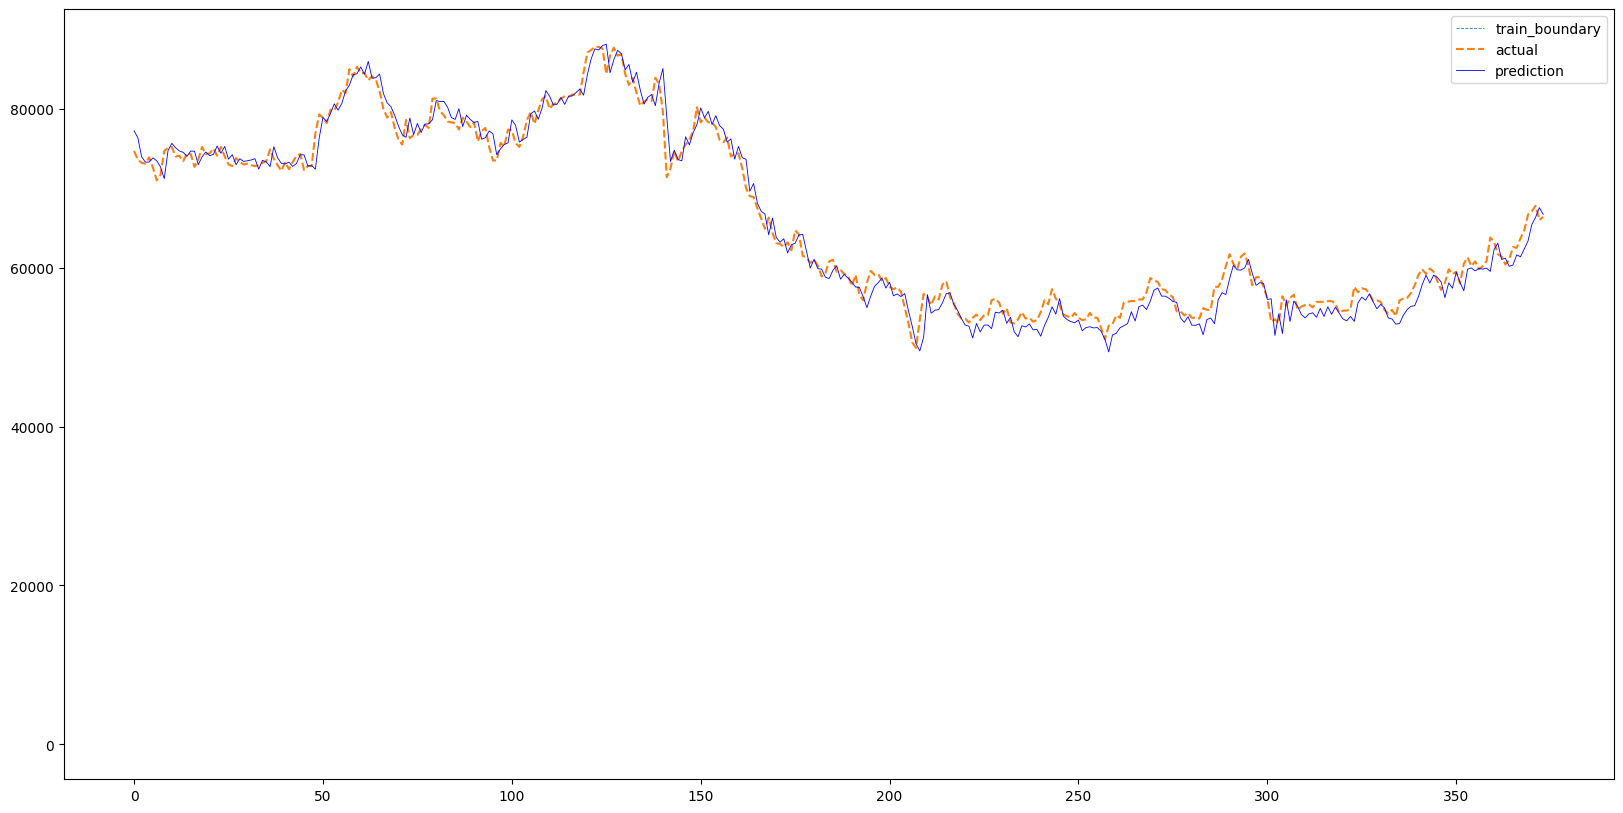

In [201]:
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values, '--', label='actual')
pred_array = np.array(pred)
pred_inverse = scaler_y.inverse_transform(pred_array.reshape(-1, 1))
plt.plot(pred_inverse, 'b', linewidth=0.6, label='prediction')
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [179]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [180]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [181]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [182]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [183]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2614
[epoch: 10] loss: 0.0052
[epoch: 20] loss: 0.0046
[epoch: 30] loss: 0.0045
[epoch: 40] loss: 0.0043


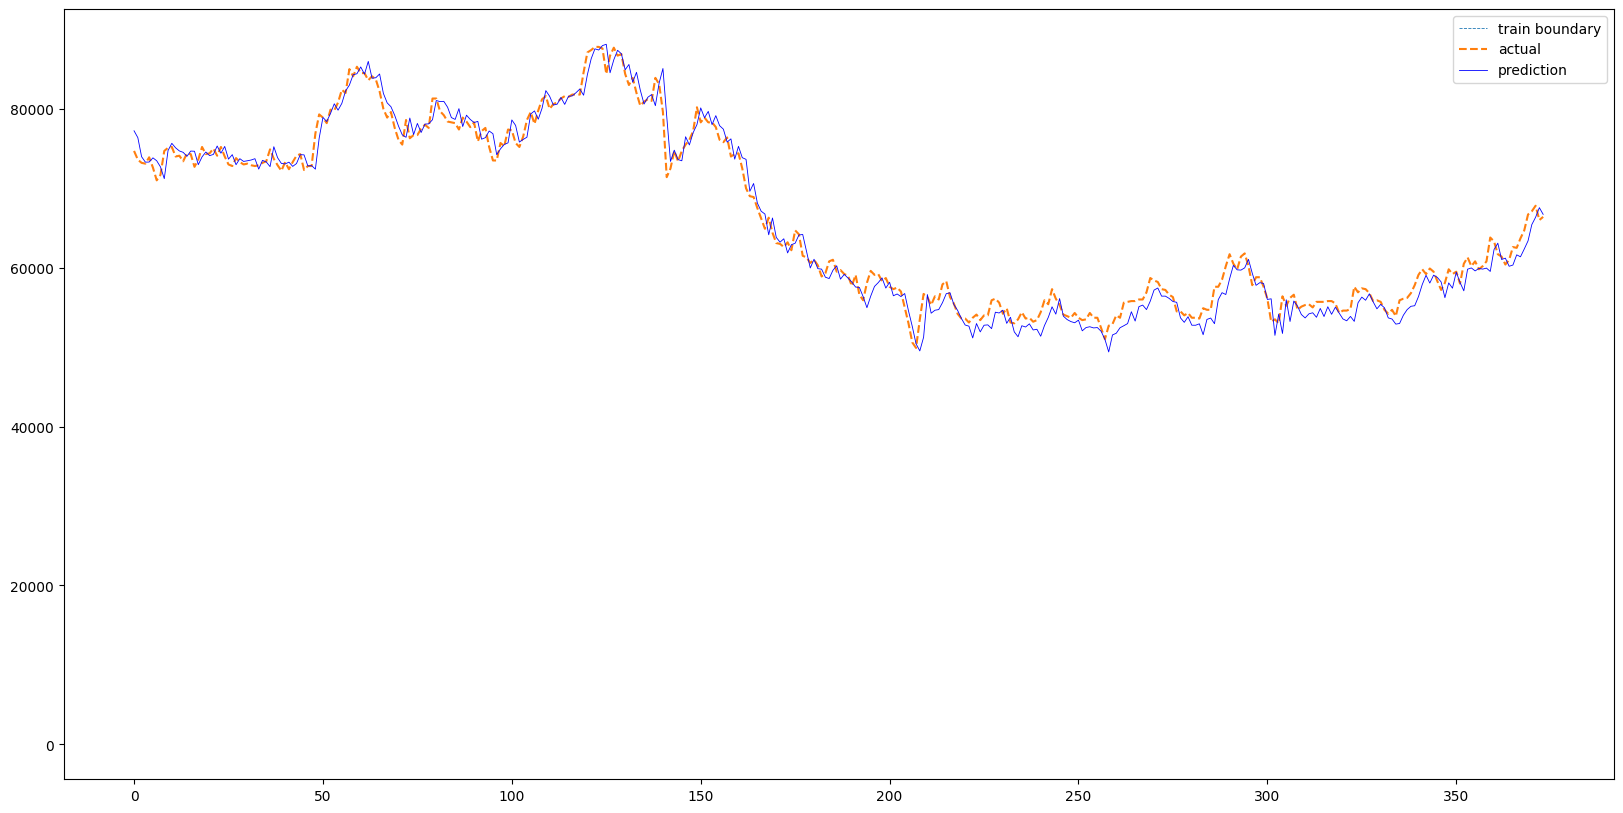

In [202]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

pred_array = np.array(pred).reshape(-1, 1)
pred_inverse = scaler_y.inverse_transform(pred_array)

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--', label='actual')
plt.plot(pred_inverse, 'b', linewidth=0.6, label='prediction')
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [203]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2024-01-02  202000  202500  199800  200500   373050 -0.014742
2024-01-03  199100  199500  193800  193800   548675 -0.033416
2024-01-04  192000  192800  189100  190000   505979 -0.019608
2024-01-05  190100  190500  187200  187300   440219 -0.014211
2024-01-08  187600  188900  185500  185700   323498 -0.008542
...            ...     ...     ...     ...      ...       ...
2025-07-17  208500  212000  205500  210000   611349  0.012048
2025-07-18  210000  212500  208500  210500   317353  0.002381
2025-07-21  209500  210500  208000  209000   460835 -0.007126
2025-07-22  209000  209500  204500  206500   441603 -0.011962
2025-07-23  213000  223000  213000  222000  2832242  0.075061

[379 rows x 6 columns]>